Data loading

In [1]:
from google.colab import files
uploaded = files.upload()

Saving GENM.csv to GENM.csv


Load libraries

In [15]:
import numpy as np
import io
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

In [3]:
df = pd.read_csv(io.BytesIO(uploaded['GENM.csv']), index_col='Date', parse_dates=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,2.20,2.32,2.20,2.28,1.232626,9380000.0
2000-01-04,2.28,2.32,2.22,2.24,1.211000,9640000.0
2000-01-05,2.18,2.24,2.14,2.20,1.189376,14240000.0
2000-01-06,2.20,2.24,2.16,2.16,1.167751,6640000.0
2000-01-07,2.16,2.16,2.16,2.16,1.167751,0.0
...,...,...,...,...,...,...
2021-05-21,2.58,2.65,2.55,2.65,2.650000,16450400.0
2021-05-24,2.60,2.74,2.58,2.69,2.690000,16665900.0
2021-05-25,2.68,2.76,2.67,2.75,2.750000,13859600.0


Data exploratory

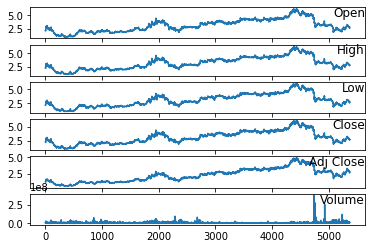

In [4]:
data = df.values
features = [0, 1, 2, 3, 4, 5]
i = 1

plt.figure()
for feature in features:
    plt.subplot(len(features), 1, i)
    plt.plot(data[:, feature])
    plt.title(df.columns[feature], y=0.5, loc='right')
    i += 1
plt.show()

Removing null values in the data set

In [5]:
df = df.dropna()

Data Transformation Functions

In [6]:
def difference_for_series(dataset, interval=1):
  diff = []

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return Series(diff)

In [7]:
def difference_for_entire_df(dataset, interval=1):
  df = DataFrame(dataset)
  column_names = list(df.columns.values)
  columns = [difference_for_series(df.iloc[:,i], interval=1) for i in range(0, df.shape[1])]
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  df.columns = column_names
  return df

In [8]:
def create_lag_column(data, lags=[-1]):
  df = DataFrame(data)
  column_names = list(df.columns.values)
  columns = []
  columns.append(df)

  for lag in lags:
    column_names.append(f'Next {-lag} Close Day')
    column = df['Close'].shift(lag)
    columns.append(column)

  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  df.drop(df.tail(-min(lags)).index, inplace=True)
  df.columns = column_names
  return df

In [9]:
def scale(train, test):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)
  train_scaled = scaler.transform(train)
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

In [10]:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [11]:
def invert_scale(scaler, X, values, target_size=1):
  row_for_transform_undo = [x for x in X] + [value for value in values]
  array_for_transform_undo = np.array(row_for_transform_undo)
  array_for_transform_undo = array_for_transform_undo.reshape(1, len(array_for_transform_undo))
  inverted = scaler.inverse_transform(array_for_transform_undo)
  return inverted[0, -target_size:]

In [16]:
def fit_gru(train, batch_size, num_epoch, neurons, target_size=1):
    X, y = train[:, 0:-target_size], train[:, -target_size:]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(GRU(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), return_sequences=True, stateful=True))
    model.add(GRU(neurons, stateful=True))
    model.add(Dense(target_size))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(num_epoch):
      model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
      model.reset_states()
    return model

In [18]:
def forecast_gru(model, batch_size, X):
  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0:3]

### LSTM for prediction of price 1 day in advance

In [19]:
diff_df = difference_for_entire_df(df, interval=1)

lag_diff_df = create_lag_column(diff_df)

train_record_size = round(0.9 * lag_diff_df.shape[0])
print("Number of records for GENM price: " + str(lag_diff_df.shape[0]))
print("Number of training records to use: " + str(train_record_size))

dataset = lag_diff_df.values
train, test = dataset[0:train_record_size], dataset[train_record_size:]
print("Train set size: " + str(len(train)))
print("Test set size: " + str(len(test)))

scaler, train_scaled, test_scaled = scale(train, test)

Number of records for GENM price: 5365
Number of training records to use: 4828
Train set size: 4828
Test set size: 537


Before transformation

RMSE: 0.544


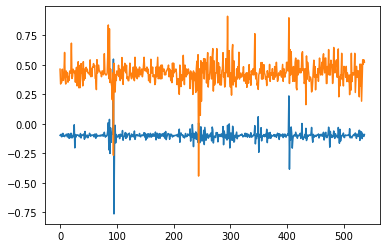

In [20]:
rmse = sqrt(mean_squared_error(test_scaled[:,5], test_scaled[:,4]))
print('RMSE: %.3f' % rmse)

plt.plot(test_scaled[:,5])
plt.plot(test_scaled[:,4])
plt.show()

After transformation

RMSE: 17960988.175


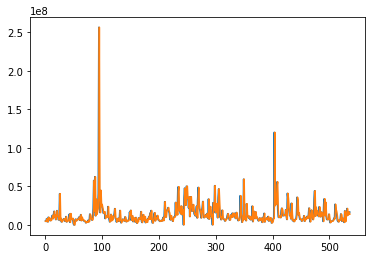

In [21]:
rmse = sqrt(mean_squared_error(df.iloc[-len(test)-1:-1,-1], df.iloc[-len(test)-2:-2,-1]))
print('RMSE: %.3f' % rmse)

plt.plot(df.iloc[-len(test)-1:-1,-1].values)
plt.plot(df.iloc[-len(test)-2:-2,-1].values)
plt.show()

GRU

In [24]:
gru_model = fit_gru(train_scaled, 1, 20, 64)
train_reshaped = train_scaled[:, 0:-1].reshape(len(train_scaled), 1, 6)
gru_model.predict(train_reshaped, batch_size=1)

predictions = list()
reverted_predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_gru(gru_model, 1, X)
    predictions.append(yhat)
    
    reverted_yhat = invert_scale(scaler, X, yhat)
    reverted_yhat = inverse_difference(df['Close'], reverted_yhat, len(test_scaled) + 1 -i)
    reverted_predictions.append(reverted_yhat)
    
predictions = np.asarray(predictions)
reverted_predictions = np.asarray(reverted_predictions)

Before transformation 

Test RMSE: 0.091


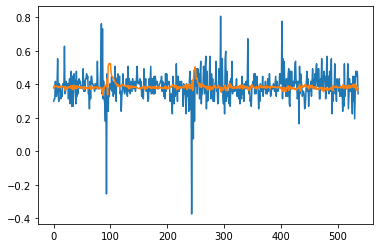

In [25]:
rmse = sqrt(mean_squared_error(test_scaled[:, -1], predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test_scaled[:, -1])
plt.plot(predictions)
plt.show()

After transformation

In [26]:
rmse = sqrt(mean_squared_error(df.iloc[-len(test)-1:-1,-1], reverted_predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(df.iloc[-len(test)-1:-1,-1])
plt.plot(reverted_predictions)
plt.show()

Test RMSE: 20373168.279


ValueError: ignored